Implementing Autoencoders

In [2]:
#Import necessary packages
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


#Part 0: Importing and Normalizing Data

In [3]:
#Load MNIST data and normalize to [0,1]
(data_train, _), (data_test, _) = mnist.load_data()
data_train = data_train/255.0
data_test = data_test/255.0
print(data_train.shape)

11501568/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)


#Part 1: Denoising AutoEncoder

In [4]:
#Reshape training and testing data into 784-dimensional vectors
#fc_ae = fully connected autoencoder
data_train_fc_ae = data_train.reshape(60000, 784)
data_test_fc_ae = data_test.reshape(10000, 784)

In [5]:
#Inject noise into testing data
noise_factor = 0.25
data_train_noisy = data_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_train.shape)
data_test_noisy = data_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_test.shape)

#Clip to stay within valid (normalized) pixel range
data_train_noisy = np.clip(data_train_noisy, 0., 1.)
data_test_noisy = np.clip(data_test_noisy, 0., 1.)

#Reshape data to comply with input of denoising autoencoder
#here I chose the architecture of part 1 to design a denoising autoencoder
data_train_noisy_fc_ae = data_train_noisy.reshape(-1,784)
data_test_noisy_fc_ae = data_test_noisy.reshape(-1,784)

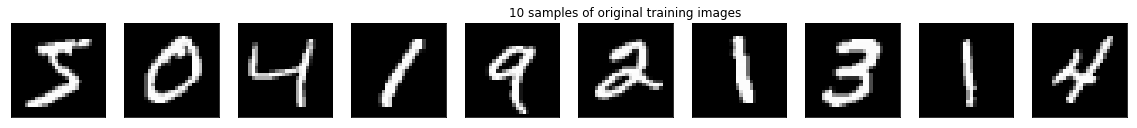

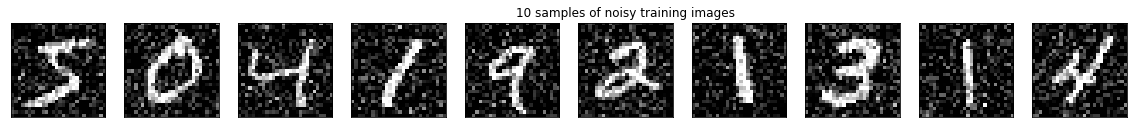

In [11]:
#Show samples of 10 original images 
n=10
plt.figure(figsize = (20,4))
for i in range(n):
  ax_train_orig = plt.subplot(1,n,i+1)
  plt.imshow(data_train[i].reshape(28,28))
  plt.gray()
  ax_train_orig.get_xaxis().set_visible(False)
  ax_train_orig.get_yaxis().set_visible(False)
  if i == 5:
    ax_train_orig.set_title('10 samples of original training images')

#Show samples of 10 corrsponding noisy counterparts from the training set
plt.figure(figsize = (20,4))
for i in range(n):
  ax_train_noisy = plt.subplot(1,n,i+1)
  plt.imshow(data_train_noisy[i].reshape(28,28))
  plt.gray()
  ax_train_noisy.get_xaxis().set_visible(False)
  ax_train_noisy.get_yaxis().set_visible(False)
  if i == 5:
    ax_train_noisy.set_title('10 samples of noisy training images')

In [6]:
#Create denoising autoencoder architecture
def dae():

    model = Sequential()
    #input layer
    model.add(Dense(400, activation = "relu", use_bias = True, bias_initializer="zeros", kernel_initializer= "uniform", input_dim = 784))
    #first hidden layer
    model.add(Dense(200, activation = "relu", use_bias = True, bias_initializer = "zeros", kernel_initializer = "uniform", input_dim = 400))
    #Third layer (bottleneck layer)
    model.add(Dense(100, activation = "relu", use_bias = True, bias_initializer = "zeros", kernel_initializer = "uniform", input_dim = 200))
    #forth layer
    model.add(Dense(200, activation = "relu", use_bias = True, bias_initializer = "zeros", kernel_initializer = "uniform", input_dim = 100))
    #fifth layer
    model.add(Dense(400, activation = "relu", use_bias = True, bias_initializer = "zeros", kernel_initializer = "uniform", input_dim = 200))
    #output layer
    model.add(Dense(784, activation = "sigmoid", use_bias = True, bias_initializer = "zeros", kernel_initializer = "uniform", input_dim = 400 ))
    return model

    return model
  

  
#Create deep denoising autoencoder graph
dae_model = dae()
#Compile model using an appropriate loss and optimizer algorithm
dae_model.compile(loss = 'mean_squared_error', optimizer = 'RMSprop', metrics = ['accuracy'])

#Train the model and assign training meta-data to a variable
dae_model_history = dae_model.fit(data_train_noisy_fc_ae, data_train_fc_ae, validation_data = (data_test_noisy_fc_ae,data_test_fc_ae), epochs = 150, batch_size = 1024, shuffle = True)

#Calculate the reconstructions of the testing set (output of autoencoder on test set)
reconstructions_dae = dae_model.predict(data_test_fc_ae)

#Obtain encoder representation of data
get_hl = K.function([dae_model.layers[0].input], [dae_model.layers[2].output]) #The third hidden layer is indexed at 2
model_hl = get_hl([data_test_fc_ae])[0]

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 6s 102us/step - loss: 0.0777 - accuracy: 0.0088 - val_loss: 0.0665 - val_accuracy: 0.0143
Epoch 2/150
60000/60000 [==============================] - 6s 98us/step - loss: 0.0657 - accuracy: 0.0099 - val_loss: 0.0649 - val_accuracy: 0.0065
Epoch 3/150
60000/60000 [==============================] - 6s 99us/step - loss: 0.0622 - accuracy: 0.0110 - val_loss: 0.0595 - val_accuracy: 0.0058
Epoch 4/150
60000/60000 [==============================] - 6s 99us/step - loss: 0.0587 - accuracy: 0.0119 - val_loss: 0.0569 - val_accuracy: 0.0069
Epoch 5/150
60000/60000 [==============================] - 6s 99us/step - loss: 0.0547 - accuracy: 0.0125 - val_loss: 0.0519 - val_accuracy: 0.0144
Epoch 6/150
60000/60000 [==============================] - 6s 100us/step - loss: 0.0517 - accuracy: 0.0120 - val_loss: 0.0496 - val_accuracy: 0.0071
Epoch 7/150
60000/60000 [==============================] - 6

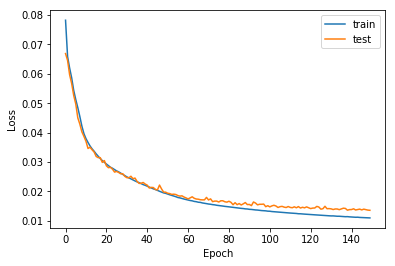

In [15]:
#Plot loss vs epoch
plt.plot(dae_model_history.history['loss'])
plt.plot(dae_model_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'], loc = 'best')

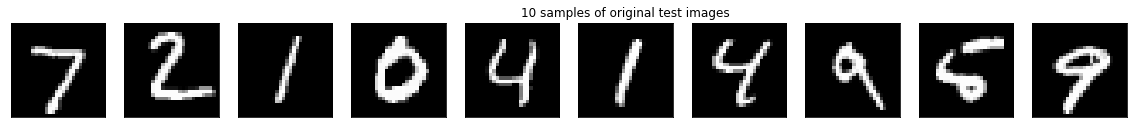

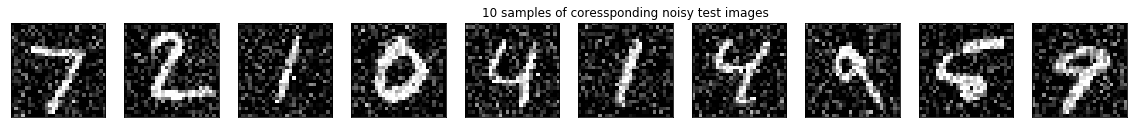

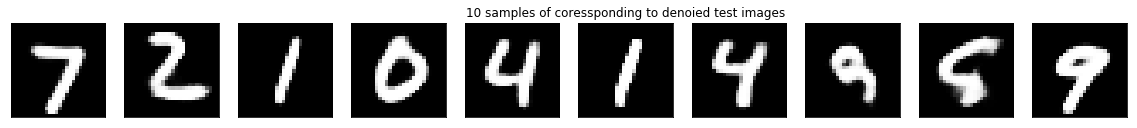

In [7]:
#Show samples of 10 original images from the testing set
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  ax_test_orig = plt.subplot(1,n,i+1)
  plt.imshow(data_test[i].reshape(28,28))
  plt.gray()
  ax_test_orig.get_xaxis().set_visible(False)
  ax_test_orig.get_yaxis().set_visible(False)
  if i == 5:
    ax_test_orig.set_title('10 samples of original test images')

#Show samples of 10 coressponding noisy counterparts from the testing set
plt.figure(figsize=(20,4))
for i in range(n):
  ax_test_orig = plt.subplot(1,n,i+1)
  plt.imshow(data_test_noisy[i].reshape(28,28))
  plt.gray()
  ax_test_orig.get_xaxis().set_visible(False)
  ax_test_orig.get_yaxis().set_visible(False)
  if i == 5:
    ax_test_orig.set_title('10 samples of coressponding noisy test images')

#Show samples of 10 coressponding de-noised images from the testing set
plt.figure(figsize=(20,4))
for i in range(n):
  ax_test_orig = plt.subplot(1,n,i+1)
  plt.imshow(reconstructions_dae[i].reshape(28,28))
  plt.gray()
  ax_test_orig.get_xaxis().set_visible(False)
  ax_test_orig.get_yaxis().set_visible(False)
  if i == 5:
    ax_test_orig.set_title('10 samples of coressponding to denoied test images')